### Étape 1. Analyse exploratoire des données.

Le dataset sur les tumeurs cérébrales contient 2 dossiers "non" et "oui" avec 98 et 155 images chacun.
En utilisant le module imutils, nous allons extraire les chemins pour toutes les images et les stockerons dans une liste appelée image_paths.

In [1]:
from imutils import paths
import matplotlib.pyplot as plt
import argparse
import os
import cv2

In [2]:
# Chargons les répertoires d'images
path = "C:\\Users\\user\\Python Projects\\Brain Tumor Classification\\brain_tumor_dataset"
#image_paths = list(paths.list_images(path))

In [3]:
print(os.listdir(path))

['no', 'yes']


In [4]:
image_paths = list(paths.list_images(path))

print(len(image_paths))

253


Maintenant, nous allons itérer sur chacun des chemins et extraire le nom du répertoire (non ou oui dans notre cas, qui sert d'étiquette), et redimensionnons l'image à 224×224 pixels.

La fonction imread() du module cv2 convertit les images de tumeurs cérébrales en informations de type pixel.


In [5]:
images = []
labels= []

for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    
    images.append(image)
    labels.append(label)

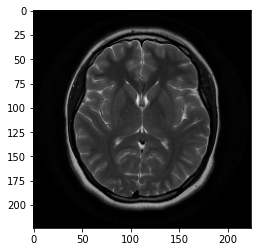

In [6]:
# Traçons une image.

def plot_image(image):
    plt.imshow(image)

plot_image(images[0])

Comme on peut le voir, nous avons stocké l'image et son étiquette respective dans des listes. Mais les étiquettes sont des chaînes de caractères qui ne peuvent pas être interprétées par des machines. 

Il faut donc appliquer l'encodage One-hot aux étiquettes et normaliser les images et aussi convertir nos listes en tableaux numpy pour diviser davantage notre jeu de données.

In [7]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
import numpy as np

In [8]:
images = np.array(images) / 255.0
labels = np.array(labels)

label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(labels)
labels = to_categorical(labels)

Avant de poursuivre, divisons notre dataset en train set et test set dans un rapport de 9-1 à l'aide de la fonction train_test_split() du package Scikit-learn.

In [9]:
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(images, labels, test_size= 0.10, random_state= 42, stratify= labels)

### Étape 2 : Construction d'un modèle CNN

Avant de construire l'architecture de notre classificateur, nous devons comprendre ce qu'est un CNN.

Un réseau neuronal convolutif, ou Convolutional Neural Network (CNN en abrégé), est un réseau neuronal profond largement utilisé pour l'analyse des images visuelles. Ces types de réseaux fonctionnent bien pour des tâches comme la classification et la détection d'images, la segmentation d'images. Un CNN se compose de deux parties principales :

* Une couche convolutive qui fait le travail d'extraction des caractéristiques.
* Une couche entièrement connectée à la fin qui utilise la sortie des couches convolutionnelles et prédit la classe de l'image.

TensorFlow fournit ImageDataGenerator qui est utilisé pour l'augmentation des données (Data Augmentation). L'augmentation des données est extrêmement utile dans les cas où les données d'entrée sont très limitées. Nous utilisons donc différentes transformations pour augmenter la taille de l'ensemble de données. Il fournit diverses transformations comme la rotation, le retournement des images horizontalement, verticalement, le zoom, etc...

Nous utiliserons les transformations fill_mode et rotation_range pour remplir les pixels hors limites avec le pixel "le plus proche" d'eux et inclure une rotation de 15 degrés aux images.

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
train_generator = ImageDataGenerator(fill_mode= 'nearest', rotation_range= 15)

Comme la taille du dataset est très petite pour entraîner de tels réseaux neuronaux profonds, nous utiliserons la puissance du Transfer Learning pour faire les meilleures prédictions. 

Le Transfer Learning consiste à exploiter les représentations des caractéristiques d'un modèle pré-entraîné, afin de ne pas avoir à former un nouveau modèle à partir de zéro.
Pour ce projet, nous utiliserons le modèle de réseau de pointe VGG16. Il existe un certain nombre de modèles pré-entraînés pouvant être utilisés dans Keras.(Voir l'architecture du modèle VGG16 sur internet).

In [12]:
# Nous supprimerons la dernière couche du réseau VGG16 et ajoutons des couches adaptées à notre problème.

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.applications import VGG16

In [13]:
base_model = VGG16(weights= 'imagenet', input_tensor= Input(shape = (224, 224, 3)), include_top= False)
base_input = base_model.input

In [14]:
base_output = base_model.output
base_output = AveragePooling2D(pool_size=(4, 4))(base_output)
base_output = Flatten(name="flatten")(base_output)
base_output = Dense(64, activation="relu")(base_output)
base_output = Dropout(0.5)(base_output)
base_output = Dense(2, activation="softmax")(base_output)

En gélant les couches de notre modèle, le réseau n'est pas formé dès le début. Il utilisera les poids des couches précédentes et poursuivra la formation pour les couches que nous avons ajoutées par-dessus ces couches. Cela réduit considérablement le temps de formation.

In [15]:
for layer in base_model.layers:
    layer.trainable = False

Maintenant, construisons le modèle et compilons-le en utilisant Adam comme optimiseur avec un taux d'apprentissage de 0,001 et la précision comme métrique. Comme nous construisons un classificateur binaire et que l'entrée est une image, l'entropie croisée binaire est utilisée comme fonction de perte.

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [17]:
model = Model(inputs = base_input, outputs = base_output)
model.compile(optimizer= Adam(learning_rate= 1e-3), metrics= ['accuracy'], loss= 'binary_crossentropy')

In [18]:
# Voyons l'architecture de notre modèle:

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Étape 3 : Entraînement et évaluation du modèle

Avant de commencer l'entraînement de notre modèle, enregistrons les hyperparamètres suivants.
Le modèle sera entraîné sur 10 époques (itérations complètes) avec train_steps pour l'ensemble d'entraînement et validation_steps pour l'ensemble de validation dans chaque époque. La taille du lot pour chaque époque est de 8.

In [19]:
batch_size = 8
train_steps = len(X_train) // batch_size
validation_steps = len(X_test) // batch_size
epochs = 10

In [20]:
history = model.fit_generator(train_generator.flow(X_train, y_train, batch_size= batch_size),
                                                   steps_per_epoch= train_steps, 
                                                   validation_data = (X_test, y_test), 
                                                   validation_steps= validation_steps,
                                                   epochs= epochs)

C:\Users\user\AppData\Local\Temp\ipykernel_12968\323400481.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator.flow(X_train, y_train, batch_size= batch_size),


Epoch 1/10
28/28 [==============================] - 129s 5s/step - loss: 0.6916 - accuracy: 0.5799 - val_loss: 0.6248 - val_accuracy: 0.6154
Epoch 2/10
28/28 [==============================] - 113s 4s/step - loss: 0.6605 - accuracy: 0.6164 - val_loss: 0.5872 - val_accuracy: 0.6154
Epoch 3/10
28/28 [==============================] - 108s 4s/step - loss: 0.6278 - accuracy: 0.6667 - val_loss: 0.5385 - val_accuracy: 0.7308
Epoch 4/10
28/28 [==============================] - 107s 4s/step - loss: 0.6141 - accuracy: 0.6758 - val_loss: 0.5038 - val_accuracy: 0.8846
Epoch 5/10
28/28 [==============================] - 96s 3s/step - loss: 0.5833 - accuracy: 0.7123 - val_loss: 0.4857 - val_accuracy: 0.9615
Epoch 6/10
28/28 [==============================] - 96s 4s/step - loss: 0.5829 - accuracy: 0.7078 - val_loss: 0.5125 - val_accuracy: 0.9231
Epoch 7/10
28/28 [==============================] - 97s 3s/step - loss: 0.5650 - accuracy: 0.7671 - val_loss: 0.4467 - val_accuracy: 0.9615
Epoch 8/10
28/28

Notre modèle a obtenu une précision d'environ 96 % sur l'ensemble de test.

Évaluons maintenant notre modèle à l'aide de la fonction predict().

In [21]:
from sklearn.metrics import classification_report, confusion_matrix

In [22]:
predictions = model.predict(X_test, batch_size= batch_size)
predictions = np.argmax(predictions, axis= 1)
actuals = np.argmax(y_test, axis= 1)

print(classification_report(actuals, predictions, target_names= label_binarizer.classes_))


cm = confusion_matrix(actuals, predictions)
print(cm)

              precision    recall  f1-score   support

          no       0.91      1.00      0.95        10
         yes       1.00      0.94      0.97        16

    accuracy                           0.96        26
   macro avg       0.95      0.97      0.96        26
weighted avg       0.97      0.96      0.96        26

[[10  0]
 [ 1 15]]


Les prédictions faites par le modèle seront un tableau dont chaque valeur représente la probabilité que l'image appartienne à cette catégorie. Nous prenons donc le maximum de toutes ces probabilités et attribuons l'étiquette prédite à cette entrée d'image.

Une matrice de confusion est une représentation matricielle montrant comment le modèle entraîné prédit chaque classe cible par rapport aux comptes. Elle contient 4 valeurs dans le format suivant :

    TP FN
    FP TN

* Vrai positif (TP) : La cible est positive et le modèle l'a prédite comme positive.
* Faux négatif (FN) : La cible est positive et le modèle l'a prédite comme négative.
* Faux positif (FP) : La cible est négative et le modèle l'a prédite comme positive.
* Vrai négatif (TN) : La cible est négative et le modèle l'a prédite comme négative.

Le rapport de classification fournit un résumé des mesures de précision, de rappel et de score F1 pour chaque classe/étiquette de l'ensemble de données. Il fournit également la précision et le nombre d'échantillons de données de chaque étiquette catégorisée.


### Précision globale du modèle.

Trouvons maintenant la précision globale du modèle en utilisant la formule : (TP + TN) / (TP + FN + FN + TN)

In [23]:
total = sum(sum(cm))
accuracy = (cm[0, 0] + cm[1, 1]) / total
print("La précision globale de notre modèle est de: {:.4f}".format(accuracy))

La précision globale de notre modèle est de: 0.9615


In [24]:
# Tracons les métriques en utilisant matplotlib

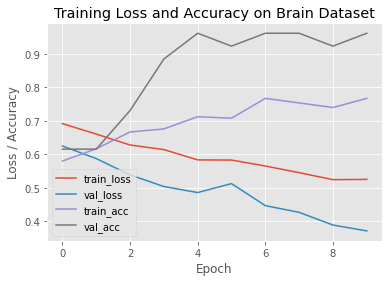

In [27]:
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label= "train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label= "val_loss")

plt.plot(np.arange(0, N), history.history["accuracy"], label= "train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label= "val_acc")

plt.title("Training Loss and Accuracy on Brain Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.legend(loc= "lower left")
plt.savefig("Training Loss and Accuracy on Brain Dataset.jpg")

Dans le cadre de la classification des tumeurs cérébrales par apprentissage automatique, nous avons construit un classificateur binaire pour détecter les tumeurs cérébrales à partir d'images IRM. 
Nous avons construit notre classificateur en utilisant transfer learning et avons obtenu une précision d'environ 96 % et visualisé la performance globale de notre modèle.